# Network Perturbations
In this notebook, I want to perturb the PPI network underlying the feature vectors to test the robustness of our GCN model with respect to the network.

I would like to remove existing edges from 

In [37]:
import pandas as pd
import numpy as np
import gcnIO
import networkx as nx
import h5py, os

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='Times New Roman')
%matplotlib inline

## Load Data
Load some existing hdf5 file from disk.

In [72]:
input_data_path = '../data/pancancer/all_omics_IREF/IREF_multiomics.h5'

data = gcnIO.load_hdf_data(input_data_path, feature_name='features')
adj, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feature_names = data
print("Read data from: {}".format(input_data_path))

Read data from: ../data/pancancer/all_omics_IREF/IREF_multiomics.h5


## Create random network with similar node degree

In [3]:
adj_names = pd.DataFrame(adj, index=node_names[:, 1], columns=node_names[:, 1])
G = nx.from_pandas_adjacency(adj_names)

In [51]:
def swap_edges(G, percentage):
    H = G.copy()
    n_swaps = int(G.number_of_edges() * percentage)
    swaps = nx.connected_double_edge_swap(H, nswap=n_swaps)
    print ("Tried {} swaps and succeeded with {}".format(n_swaps, swaps))
    return H

swapping_percentages = [0, 0.5, 1]
perturbed_networks = [G]
for percentages in swapping_percentages[1:]:
    perturbed_networks.append(swap_edges(G, percentages))
    print ("Created network with {}% swapped edges".format(percentages*100))

Tried 45904 swaps and succeeded with 42417
Created network with 50.0% swapped edges
Tried 91809 swaps and succeeded with 85557
Created network with 100% swapped edges


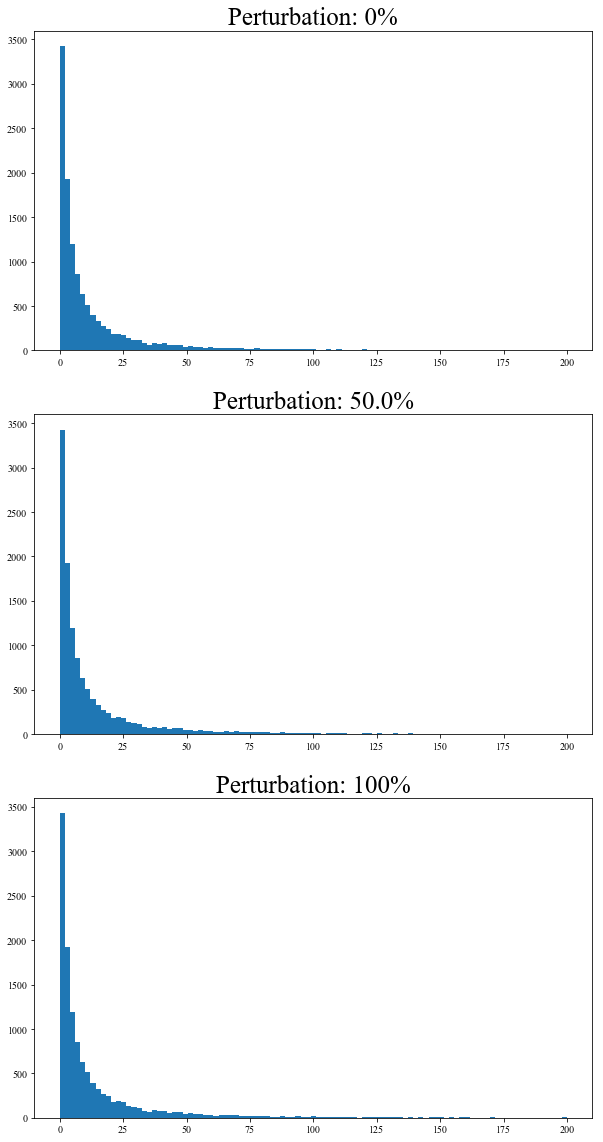

In [52]:
fig = plt.figure(figsize=(10, 20))
bins = np.linspace(0, 200, 100)

for i in range(len(swapping_percentages)):
    plt.subplot(len(swapping_percentages), 1, i+1)
    _ = plt.hist([v for k, v in perturbed_networks[i].degree()], bins)
    plt.title("Perturbation: {}%".format(swapping_percentages[i]*100), size=25)

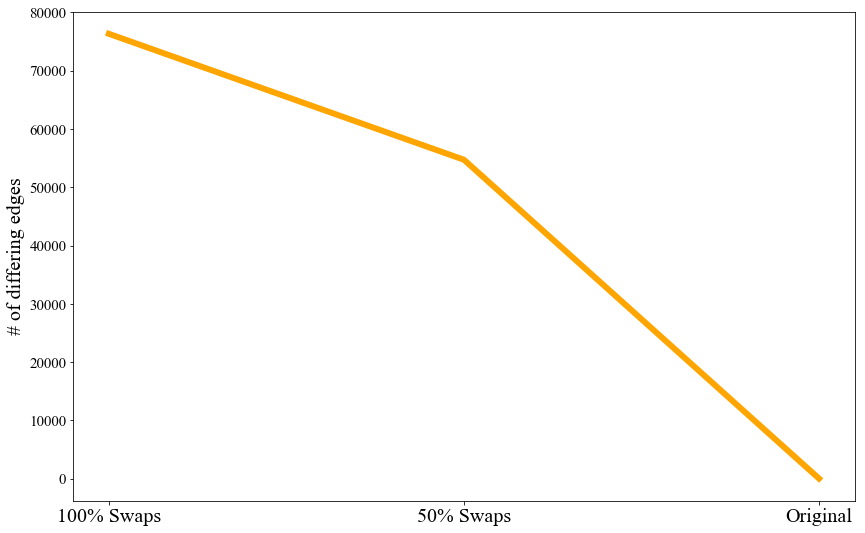

In [55]:
def _get_number_of_different_edges(original, perturbed):
    edges_removed_from_original = 0
    for edge in original.edges():
        if not perturbed.has_edge(*edge):
            edges_removed_from_original += 1
    return edges_removed_from_original

num_diff_edges = []
for Q in perturbed_networks:
    num_diff_edges.append(_get_number_of_different_edges(G, Q))

fig = plt.figure(figsize=(14, 9))
sns.lineplot(x=['Original', '50% Swaps', '100% Swaps'], y=num_diff_edges, lw=6, color='orange', ms=20)
plt.ylabel('# of differing edges', size=20)
_ = plt.xticks(size=20)
_ = plt.yticks(size=15)

## Write back to HDF5

In [56]:
def write_hdf5_container(fname, adj, F, node_names, y_train, y_val, y_test, train_mask, val_mask, test_mask, feature_names, features_raw):
    f = h5py.File(fname, 'w')
    string_dt = h5py.special_dtype(vlen=str)
    f.create_dataset('network', data=adj, shape=adj.shape)
    f.create_dataset('features', data=F, shape=F.shape)
    f.create_dataset('gene_names', data=node_names, dtype=string_dt)
    f.create_dataset('y_train', data=y_train, shape=y_train.shape)
    f.create_dataset('y_val', data=y_val, shape=y_val.shape)
    f.create_dataset('y_test', data=y_test, shape=y_test.shape)
    f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
    f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
    f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
    f.create_dataset('feature_names', data=np.array(feature_names, dtype=object), dtype=string_dt)
    f.create_dataset('features_raw', data=features_raw, shape=features_raw.shape)
    f.close()

    print ("Container written to {}".format(fname))

In [59]:
perturbation_folder = '/project/gcn/diseasegcn/data/network_perturbation2/'

if not os.path.isdir(perturbation_folder):
    os.mkdir(perturbation_folder)
else:
    for file in os.listdir(perturbation_folder):
        os.remove(os.path.join(perturbation_folder, file))

for i in range(len(swapping_percentages)):
    fname = os.path.join(perturbation_folder, 'IREF_{}_perturbation.h5'.format(str(swapping_percentages[i]).replace('.', '_')))
    write_hdf5_container(fname, nx.to_pandas_adjacency(perturbed_networks[i]), features, node_names,
                         y_train, y_val, y_test,
                         train_mask, val_mask, test_mask,
                         feature_names, features
                        )

Container written to /project/gcn/diseasegcn/data/network_perturbation2/IREF_0_perturbation.h5
Container written to /project/gcn/diseasegcn/data/network_perturbation2/IREF_0_5_perturbation.h5
Container written to /project/gcn/diseasegcn/data/network_perturbation2/IREF_1_perturbation.h5


# Feature Perturbations

In [110]:
def _swap_row(matrix, idx_from, idx_to):
    tmp = matrix[idx_from]
    matrix[idx_from] = matrix[idx_to]
    matrix[idx_to] = tmp

def perturb_features(features, percentage, max_tries=100):
    n_swaps = percentage * features.shape[0]
    already_perturbed = []
    for swap in range(int(n_swaps)):
        found_new_swap = False
        num_tries = 0
        while not found_new_swap or num_tries > max_tries:
            fro, to = np.random.randint(features.shape[0], size=2)
            if not (fro, to) in already_perturbed and not (to, fro) in already_perturbed:
                found_new_swap = True
                _swap_row(features, fro, to)
                already_perturbed.append((fro, to))
    return features

perturbed_features = [features]
for percentages in swapping_percentages[1:]:
    perturbed_features.append(perturb_features(features.copy(), percentages))
    print ("Swapped {}% of the features".format(percentages*100))

Swapped 50.0% of the features
Swapped 100% of the features


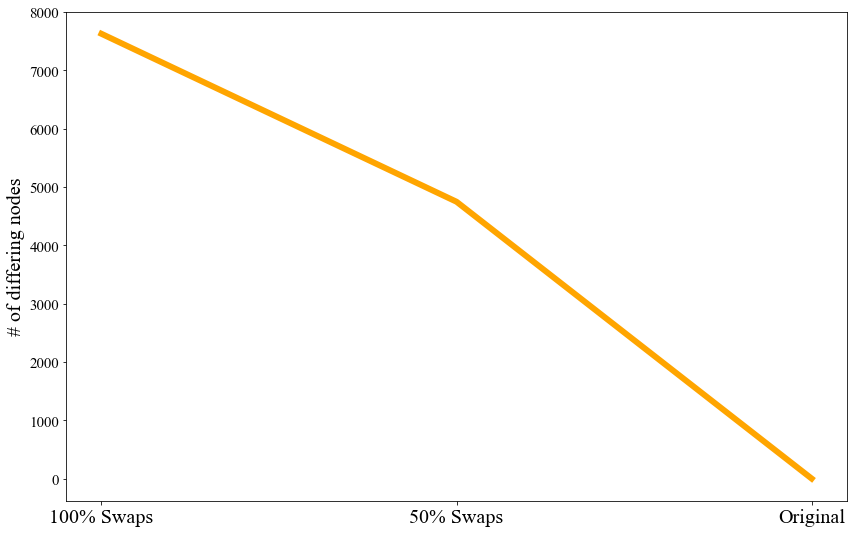

In [113]:
num_diff_rows = []
for F in perturbed_features:
    num_diff_rows.append( F.shape[0] - (F == features).all(axis=1).sum() )

fig = plt.figure(figsize=(14, 9))
sns.lineplot(x=['Original', '50% Swaps', '100% Swaps'], y=num_diff_rows, lw=6, color='orange', ms=20)
plt.ylabel('# of differing nodes', size=20)
_ = plt.xticks(size=20)
_ = plt.yticks(size=15)

In [115]:
perturbation_folder = '/project/gcn/diseasegcn/data/feature_perturbation/'

if not os.path.isdir(perturbation_folder):
    os.mkdir(perturbation_folder)
else:
    for file in os.listdir(perturbation_folder):
        os.remove(os.path.join(perturbation_folder, file))

for i in range(len(swapping_percentages)):
    fname = os.path.join(perturbation_folder, 'IREF_{}_feature_perturbation.h5'.format(str(swapping_percentages[i]).replace('.', '_')))
    write_hdf5_container(fname, adj, perturbed_features[i], node_names,
                         y_train, y_val, y_test,
                         train_mask, val_mask, test_mask,
                         feature_names, perturbed_features[i]
                        )

Container written to /project/gcn/diseasegcn/data/feature_perturbation/IREF_0_feature_perturbation.h5
Container written to /project/gcn/diseasegcn/data/feature_perturbation/IREF_0_5_feature_perturbation.h5
Container written to /project/gcn/diseasegcn/data/feature_perturbation/IREF_1_feature_perturbation.h5
